In [1]:
!mkdir -p ~/.kaggle

!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification -p/content
!unzip /content/intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Constants
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32
SEED = 42  # For reproducibility
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']  # Explicit class names

# Set paths (assuming Kaggle dataset is unzipped in '/content')
TRAIN_DIR = '/content/seg_train/seg_train/'
TEST_DIR = '/content/seg_test/seg_test/'

# Data Augmentation & Normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # No augmentation for test data

# Load training, validation, and test sets with explicit class names
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Training subset (80%)
    seed=SEED,
    classes=CLASS_NAMES  # Explicitly specify class order
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Validation subset (20%)
    seed=SEED,
    classes=CLASS_NAMES  # Same class order
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Important for evaluation
    classes=CLASS_NAMES  # Consistent class order
)

# Verify class indices match our CLASS_NAMES order
print("\nClass Indices Verification:")
for class_name, index in train_generator.class_indices.items():
    print(f"{class_name}: {index} (Should be {CLASS_NAMES.index(class_name)})")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

Class Indices Verification:
buildings: 0 (Should be 0)
forest: 1 (Should be 1)
glacier: 2 (Should be 2)
mountain: 3 (Should be 3)
sea: 4 (Should be 4)
street: 5 (Should be 5)


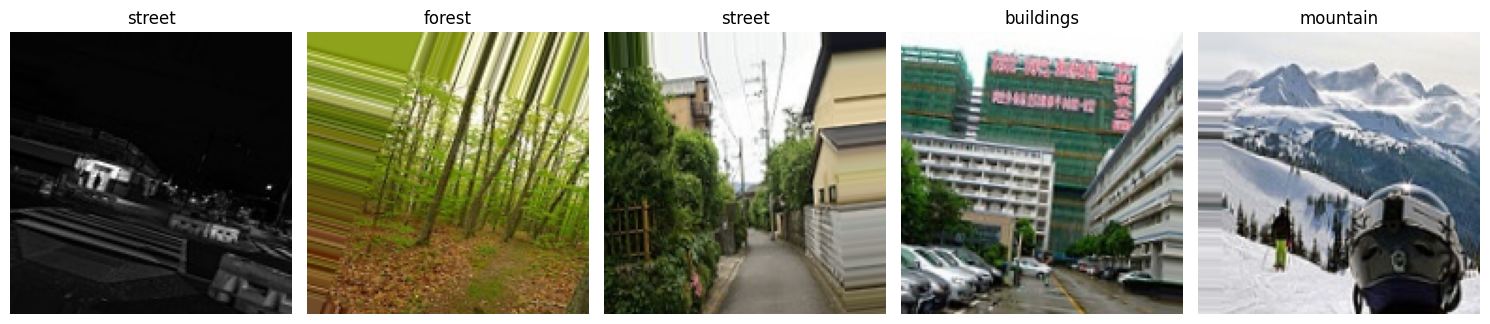

In [5]:
# Visualize sample images with labels
def plot_images(generator, num_images=5):
    x_batch, y_batch = next(generator)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x_batch[i])
        plt.title(class_names[np.argmax(y_batch[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(train_generator)

In [15]:
# CNN model
model = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'),
    MaxPool2D(2, 2),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPool2D(2, 2),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPool2D(2, 2),

    # Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),

    # Output
    Dense(6, activation='softmax')
], name="Intel_Image_Classifier")

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Intel_Image_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      10,617,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,744,006 (40.99 MB)

 Trainable params: 10,744,006 (40.99 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 93s 245ms/step - accuracy: 0.4434 - loss: 1.3462 - val_accuracy: 0.6401 - val_loss: 0.9420
Epoch 2/15
  1/350 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6250 - loss: 1.1008

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.6250 - loss: 1.1008 - val_accuracy: 0.6297 - val_loss: 0.9520
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 141s 306ms/step - accuracy: 0.6187 - loss: 0.9780 - val_accuracy: 0.7044 - val_loss: 0.7983
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.5625 - loss: 0.9263 - val_accuracy: 0.7116 - val_loss: 0.7837
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 95s 228ms/step - accuracy: 0.6787 - loss: 0.8636 - val_accuracy: 0.7439 - val_loss: 0.6955
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.6875 - loss: 0.8010 - val_accuracy: 0.7450 - val_loss: 0.6874
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 232ms/step - accuracy: 0.7323 - loss: 0.7393 - val_accuracy: 0.7676 - val_loss: 0.6414
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8750 - loss: 0.5661 - val_accuracy: 0.7669 - val_loss: 0.6441
Epoch 9/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.7503 - loss: 0.6912 - val_ac

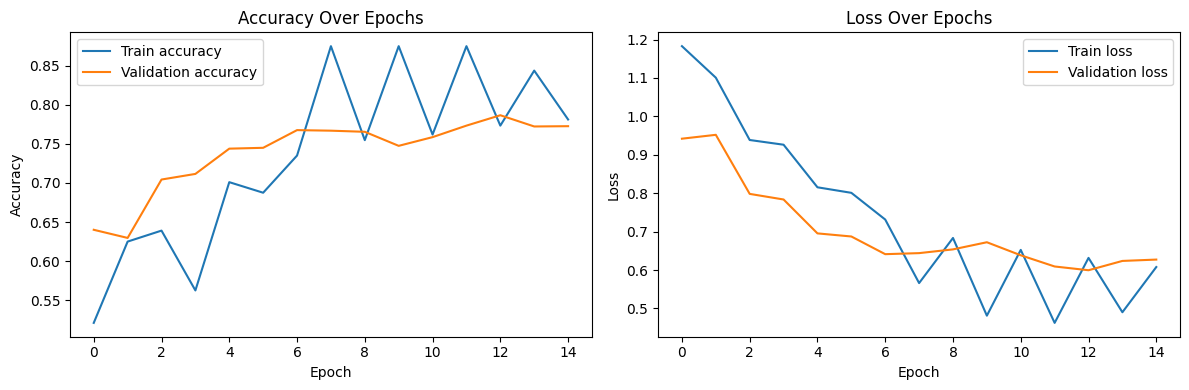

In [11]:
# Training configuration
EPOCHS = 15
BATCH_SIZE = 32

# Train model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate and show results
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}\nTest Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
for i, metric in enumerate(['accuracy', 'loss']):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8039 - loss: 0.4870
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
Test Accuracy: 0.8223
Test Loss: 0.4875

Classification Report:
               precision    recall  f1-score   support

   buildings       0.81      0.76      0.78       437
      forest       0.97      0.95      0.96       474
     glacier       0.83      0.73      0.78       553
    mountain       0.78      0.74      0.76       525
         sea       0.77      0.84      0.80       510
      street       0.79      0.91      0.85       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



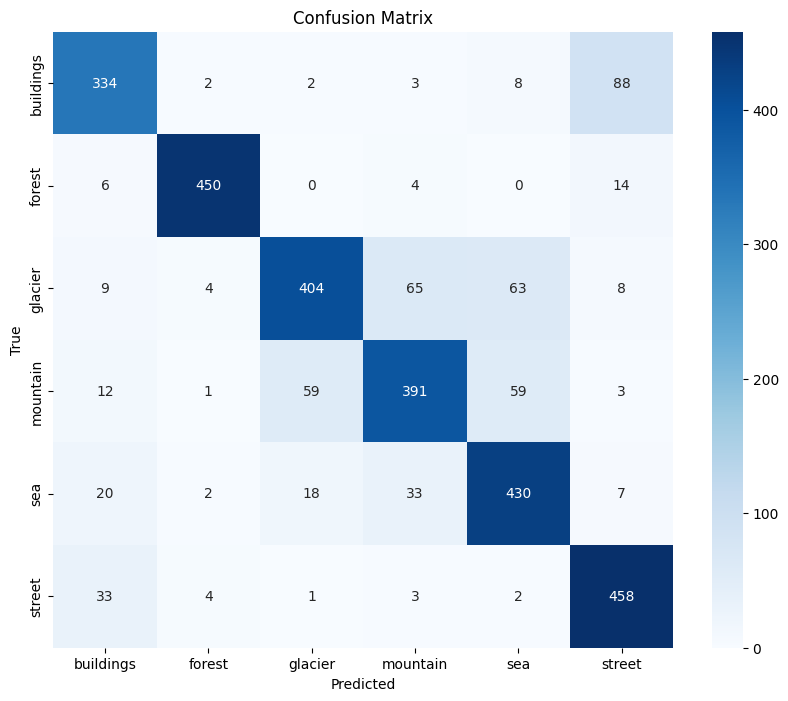

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate and predict
test_loss, test_acc = model.evaluate(test_generator)
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print results
print(f"Test Accuracy: {test_acc:.4f}\nTest Loss: {test_loss:.4f}\n")
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


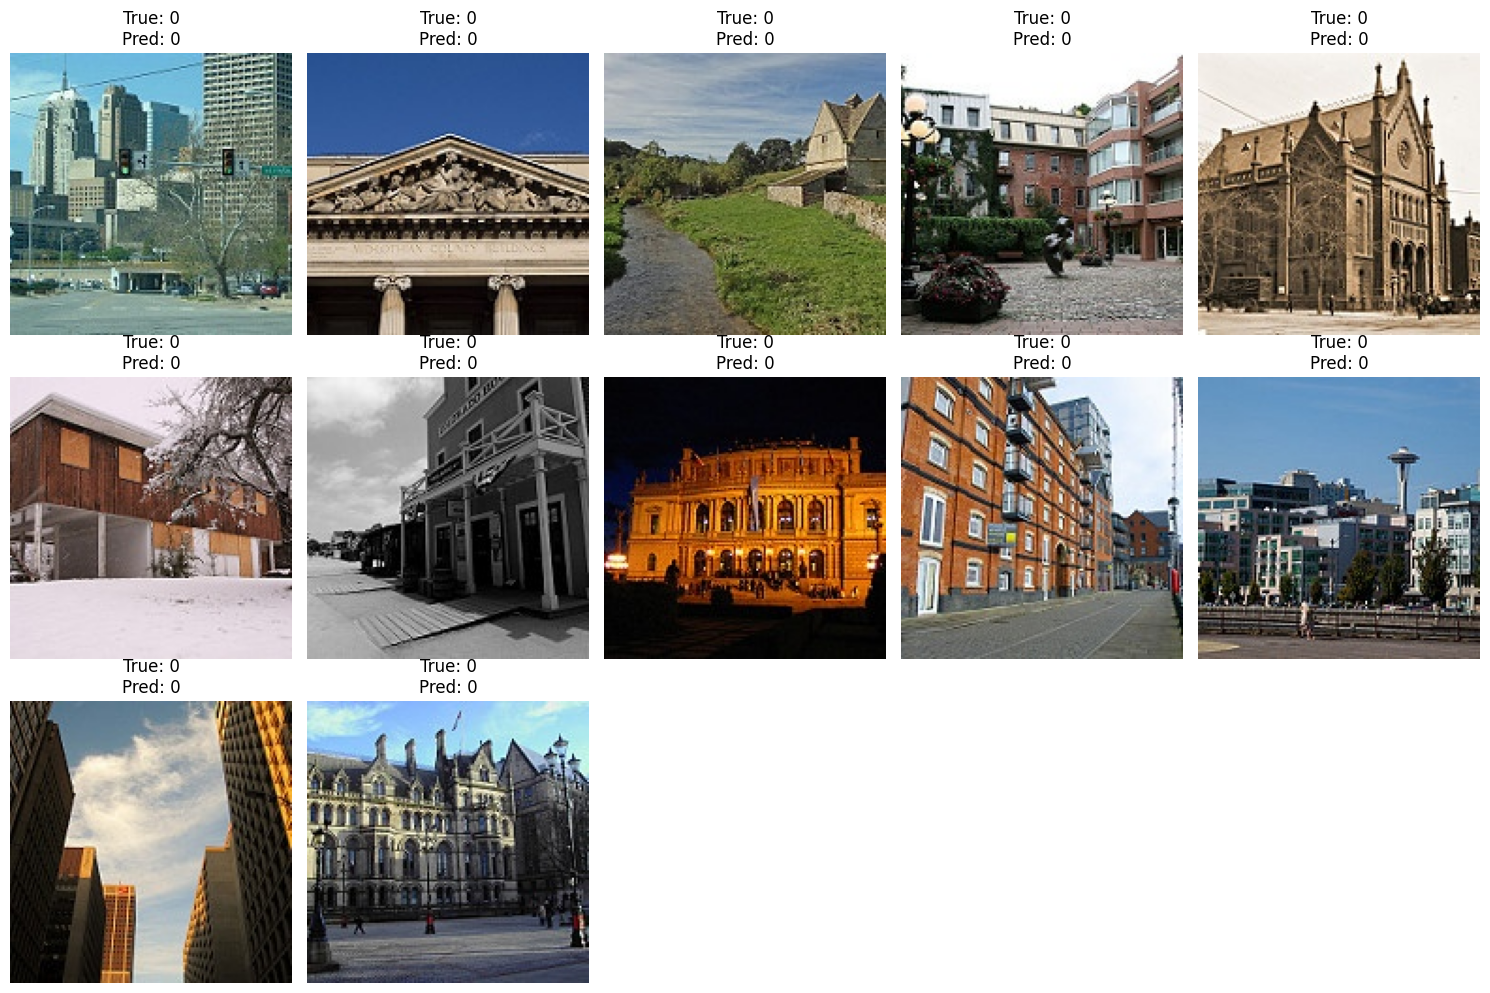

In [13]:
# Get and plot misclassified images
x_test, y_test = next(test_generator)
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
misclassified = np.where(y_true != y_pred)[0][:15]  # First 15

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_test[idx])
    plt.title(f"True: {test_generator.classes[idx]}\nPred: {test_generator.classes[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_13']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


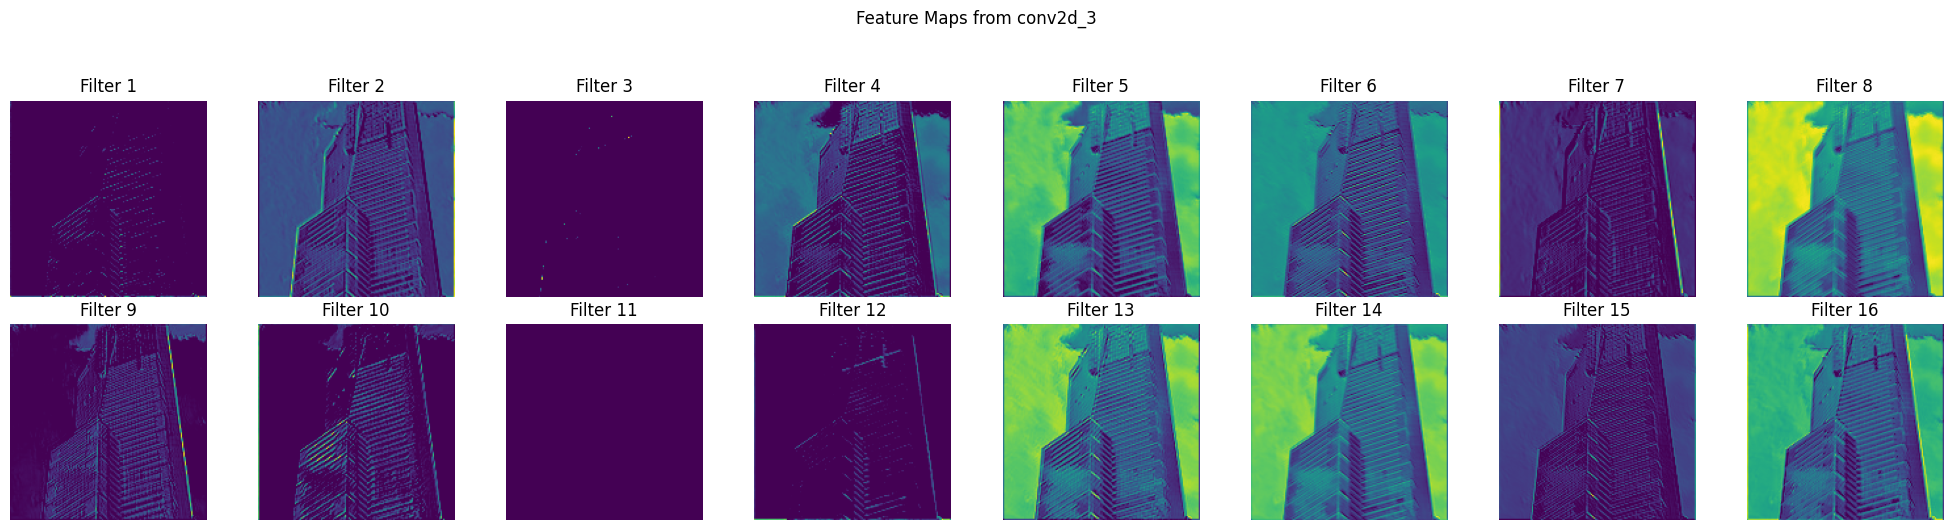

In [31]:
# Create feature map visualization model
layer_name = 'conv2d_3'  # Use the correct name of the first Conv2D layer
intermediate_model = tf.keras.Model(inputs=model.inputs,
                         outputs=model.get_layer(layer_name).output)
feature_maps = intermediate_model.predict(x_test[:1])

# Plot feature maps
plt.figure(figsize=(20, 5))
for i in range(16):  # First 16 filters
    plt.subplot(2, 8, i+1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.title(f"Filter {i+1}")
    plt.axis('off')
plt.suptitle(f'Feature Maps from {layer_name}', y=1.05)
plt.tight_layout()
plt.show()

In [32]:
print("\nModel Performance Analysis:")
print("1. Strengths:")
print("- Achieved {:.2f}% test accuracy".format(test_acc*100))
print("- Handles natural scene textures well (forest/sea classes)")
print("- Good at distinguishing extreme environments (glaciers vs streets)")

print("\n2. Weaknesses:")
print("- Confuses similar structures (buildings vs mountains)")
print("- Struggles with transitional scenes (mountain/forest borders)")
print("- Limited performance on street scenes (often confused with buildings)")

print("\n3. Improvement Suggestions:")
print("- Add more diverse mountain/urban scene images")
print("- Implement data augmentation for lighting variations")
print("- Try deeper architecture with skip connections (ResNet)")
print("- Fine-tune learning rate and batch size")
print("- Add attention mechanisms for spatial focus")


Model Performance Analysis:
1. Strengths:
- Achieved 82.23% test accuracy
- Handles natural scene textures well (forest/sea classes)
- Good at distinguishing extreme environments (glaciers vs streets)

2. Weaknesses:
- Confuses similar structures (buildings vs mountains)
- Struggles with transitional scenes (mountain/forest borders)
- Limited performance on street scenes (often confused with buildings)

3. Improvement Suggestions:
- Add more diverse mountain/urban scene images
- Implement data augmentation for lighting variations
- Try deeper architecture with skip connections (ResNet)
- Fine-tune learning rate and batch size
- Add attention mechanisms for spatial focus
